# Lending Club - Interest Rate Predictor

## Current Notebook: 4_Model_Decision Tree

---
**Author:** Rohit Singh
<br/>
[GitHub](https://github.com/rohitsinghxyz) | [LinkedIn](https://www.linkedin.com/in/rohitsinghxyz)
<br/>
<br/>
**Project:** Lending Club - Interest Rate Predictor
<br/>
<br/>
**Previous Notebook:** 3_Model_Prep
<br/>
**Current Notebook:** 4_Model_Decision Tree
<br/>
**Next Notebook:** 5_Model_Random Forest

## Table of Contents

[1. Data Import](#1)
<br/>
[2. Transformers](#2)
<br/>
[3. Decision Tree: Model Training](#3)
<br/>
[4. Decision Tree: Model Evaluation](#4)
<br/>
[5. Decision Tree: Model Predictions](#5)
<br/>
[6. Observations](#6)

---
<a id="1"></a>
## 1. Data Import

In [1]:
# Import packages
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from tempfile import mkdtemp
import shap

Let us import the Train, Validation, Remainder, and Test data sets.

In [2]:
# Import Train, Validation, Remainder, Test sets

X_remainder = joblib.load('data/X_remainder.pkl')
X_train = joblib.load('data/X_train.pkl')
X_test = joblib.load('data/X_test.pkl')
X_validation = joblib.load('data/X_validation.pkl')

y_remainder = joblib.load('data/y_remainder.pkl')
y_train = joblib.load('data/y_train.pkl')
y_test = joblib.load('data/y_test.pkl')
y_validation = joblib.load('data/y_validation.pkl')

In [3]:
# Print shapes of split sets
print(f'Shape of Test set: {X_test.shape}')
print(f'Shape of Validation set: {X_validation.shape}')
print(f'Shape of Train set: {X_train.shape}')

Shape of Test set: (416057, 15)
Shape of Validation set: (332846, 15)
Shape of Train set: (1331380, 15)


Data sets seem to have loaded correctly.

---
<a id="2"></a>
### 2. Transformers

In [4]:
# Check categorical columns
cat_columns = list(X_train.select_dtypes(include=['object', 'category']).columns)
cat_columns
print(f'Categorical columns are: {cat_columns}')

Categorical columns are: ['term', 'purpose', 'verification_status', 'home_ownership', 'disbursement_method', 'pub_rec_bin', 'pub_rec_bankruptcies_bin', 'tax_liens_bin']


In [5]:
# Check numerical columns
num_columns = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
num_columns
print(f'Numerical columns are: {num_columns}')

Numerical columns are: ['loan_amnt', 'annual_inc', 'dti', 'open_acc', 'mort_acc', 'num_bc_sats', 'fico_range_avg']


**Why encode categorical data using OneHotEncoder?**

We have few categorical columns in our data. Since order is not important in these categorical columns, we can encode them using OneHotEncoder. If order was important, we would have used OrdinalEncoder.

In [6]:
# Set up categorical pipeline
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

**Why scale numerical data using StandardScaler?**

We have few numerical columns in our data with varying scales of measurement. Hence, it makes sense to scale the data so that all attributes have the same scale. This helps machine learning algorithms perform better.

We are aware that tree-based models do not require data to be scaled.

In [7]:
# Set up numerical pipeline
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [8]:
# Set up column transformer
col_transformer = ColumnTransformer([
    ('cat', cat_pipe, cat_columns),
    ('num', num_pipe, num_columns)],
    remainder='passthrough',
    n_jobs=-1,
    verbose=3
)
col_transformer.fit(X_train)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['term', 'purpose', 'verification_status',
                                  'home_ownership', 'disbursement_method',
                                  'pub_rec_bin', 'pub_rec_bankruptcies_bin',
                                  'tax_liens_bin']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['loan_amnt', 'annual_inc', 'dti', 'open_acc',
                                  'mort_acc', 'num_bc_sats',
                                  'fico_range_avg'])],
                  verbose=3)

Let us check whether OneHotEncoder properly encoded the categorical columns or not.

In [9]:
# Prepare column names
cat_columns_names = col_transformer.named_transformers_['cat']['encoder'].get_feature_names(cat_columns)
columns = np.append(cat_columns_names, num_columns)

# Check column names
display(X_train)
display(pd.DataFrame(col_transformer.transform(X_train), columns=columns))

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,loan_amnt,term,purpose,annual_inc,verification_status,home_ownership,dti,open_acc,mort_acc,num_bc_sats,disbursement_method,fico_range_avg,pub_rec_bin,pub_rec_bankruptcies_bin,tax_liens_bin
237045,20000.0,60 months,debt_consolidation,85000.0,Verified,MORTGAGE,16.68,15.0,6.0,3.0,Cash,662.0,pub_rec_1+_bin,pub_rec_bankruptcies_1+_bin,tax_liens_0_bin
2066086,4000.0,36 months,home_improvement,112000.0,Source Verified,MORTGAGE,21.55,12.0,1.0,5.0,Cash,677.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1163134,35000.0,60 months,debt_consolidation,180000.0,Source Verified,MORTGAGE,15.55,23.0,1.0,12.0,Cash,757.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1189746,10000.0,36 months,debt_consolidation,66000.0,Not Verified,MORTGAGE,11.96,9.0,2.0,5.0,Cash,672.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1078531,6000.0,36 months,car,40000.0,Not Verified,OWN,20.28,4.0,2.0,2.0,Cash,737.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061037,30000.0,36 months,credit_card,130000.0,Source Verified,MORTGAGE,15.32,18.0,1.0,9.0,Cash,677.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
306590,28775.0,36 months,debt_consolidation,60000.0,Verified,MORTGAGE,18.56,8.0,1.0,5.0,Cash,697.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
850631,15000.0,36 months,credit_card,60000.0,Not Verified,RENT,21.82,9.0,0.0,6.0,DirectPay,702.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
740312,35000.0,36 months,debt_consolidation,90000.0,Source Verified,MORTGAGE,15.93,6.0,1.0,2.0,Cash,682.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin


,term_36 months,term_60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,...,pub_rec_bankruptcies_bin_pub_rec_bankruptcies_1+_bin,tax_liens_bin_tax_liens_0_bin,tax_liens_bin_tax_liens_1+_bin,loan_amnt,annual_inc,dti,open_acc,mort_acc,num_bc_sats,fico_range_avg
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.566806,0.042796,-0.182339,0.582379,2.333721,-0.592870,-1.160244
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.201218,0.245596,0.394588,0.052904,-0.284009,0.062837,-0.695519
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.224329,0.756349,-0.316205,1.994311,-0.284009,2.357812,1.783016
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.538209,-0.099914,-0.741496,-0.476570,0.239537,0.062837,-0.850427
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.980215,-0.295202,0.244137,-1.359027,0.239537,-0.920724,1.163382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.671822,0.380795,-0.343452,1.111853,-0.284009,1.374251,-0.695519
1331376,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.536457,-0.144981,0.040376,-0.653061,-0.284009,0.062837,-0.075885
1331377,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.014299,-0.144981,0.426574,-0.476570,-0.807555,0.390690,0.079023
1331378,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.224329,0.080352,-0.271188,-1.006044,-0.284009,-0.920724,-0.540611


We can see that OneHotEncoder has successfully encoded Categorical columns.

We can also see that Numerical columns have been scaled.

---
<a id="3"></a>
### 3. Decision Tree: Model Training

As mentioned in the previous notebook, we will focus on machine learning models that can better handle non-linear data. We will start with Decision Tree.

Instead of exploring multiple combinations one by one, we will use Pipeline and GridSearchCV/RandomizedSearchCV to find the best hyper-parameters for us. Ideally, we would have used Pipeline and GridSearchCV to try out all possible combinations. But due to the size of our data set and time/computing restraints, we will use Pipeline and RandomizedSearchCV for the time being. RandomizedSearchCV doesn't try out all possible combinations like GridSearchCV but only evaluates random combinations by selecting random values for each hyper-parameter.

**Scoring**

For scoring, we will RMSE (Root Mean Squared Error).

RMSE is an extension of the Mean Squared Error (MSE). The square root of the error is calculated, which means that the units of RMSE are the same as the original units of the target value that is being predicted.

RMSE represents the square root of the variance of the residuals. A perfect RMSE value is 0.0, which means that all predictions matched the expected values exactly. This is almost never the case.

In [10]:
%%time
# Run time ~ 50 min

# Decision Tree Regressor

# Cache memory in case of kernel crash
cachedir = mkdtemp()

# Set default values for pipeline
pipe = Pipeline([
        ('preprocessor', col_transformer),
        ('model', DecisionTreeRegressor())],
        memory=cachedir)

# Set up parameter grid
param_grid = [
    {
        # Decision Tree Regressor
        'model': [DecisionTreeRegressor(random_state=123)],
        'model__max_depth': np.arange(5, 35, 5),
        'model__min_samples_leaf': np.arange(5, 100, 10)
    }  
]

# Store results of RandomizedSearchCV as `dt_grid`
dt_grid = RandomizedSearchCV(pipe, param_grid, n_iter=100, cv=5, scoring='neg_root_mean_squared_error',\
                          return_train_score=True, n_jobs=-2, verbose=3)

# Fit grid on Train data
dt_fitgrid = dt_grid.fit(X_train, y_train)

The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/rohit/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 52.68s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/Users/rohit/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 51.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the pro

CPU times: user 7min 45s, sys: 42.9 s, total: 8min 28s
Wall time: 48min 28s
[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.9s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   6.1s
[CV 5/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.876, test=-3.870) total time= 2.5min
[CV 1/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=35;, score=(train=-3.877, test=-3.871) total time= 1.4min
[CV 2/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=55;, score=(train=-3.873, test=-3.882) total time= 1.4min
[CV 3/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=75;, score=(train=-3.873, test=-3.885) total time= 1.7min
[CV 4/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=95;, score=(train=-3.875, test=

[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.7s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   5.6s
[CV 3/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=15;, score=(train=-3.873, test=-3.885) total time= 2.5min
[CV 4/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=35;, score=(train=-3.875, test=-3.871) total time= 1.4min
[CV 5/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=55;, score=(train=-3.876, test=-3.870) total time= 1.4min
[CV 1/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=85;, score=(train=-3.877, test=-3.871) total time= 1.6min
[CV 2/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=5;, score=(train=-3.670, test=-3.702) total time= 1.7min
[CV 3/5] END model=DecisionTreeRegressor(random_

[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.7s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   6.7s
[CV 5/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=15;, score=(train=-3.876, test=-3.870) total time= 2.5min
[CV 1/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=45;, score=(train=-3.877, test=-3.871) total time= 1.4min
[CV 2/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=65;, score=(train=-3.873, test=-3.882) total time= 1.5min
[CV 3/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=85;, score=(train=-3.873, test=-3.885) total time= 1.6min
[CV 4/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=5;, score=(train=-3.672, test=-3.692) total time= 1.7min
[CV 5/5] END model=DecisionTreeRegressor(random_

[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.6s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   5.9s
[CV 1/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.877, test=-3.871) total time= 2.4min
[CV 2/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=25;, score=(train=-3.873, test=-3.882) total time= 1.3min
[CV 3/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=45;, score=(train=-3.873, test=-3.885) total time= 1.2min
[CV 4/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=65;, score=(train=-3.875, test=-3.871) total time= 1.7min
[CV 5/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=85;, score=(train=-3.876, test=-3.870) total time= 1.5min
[CV 1/5] END model=DecisionTreeRegressor(random_s

[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.7s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   6.2s
[CV 3/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.873, test=-3.885) total time= 2.4min
[CV 4/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=25;, score=(train=-3.875, test=-3.871) total time= 1.3min
[CV 5/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=45;, score=(train=-3.876, test=-3.870) total time= 1.3min
[CV 1/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=75;, score=(train=-3.877, test=-3.871) total time= 1.7min
[CV 2/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=95;, score=(train=-3.873, test=-3.882) total time= 1.5min
[CV 3/5] END model=DecisionTreeRegressor(random_s

[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.8s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   6.0s
[CV 4/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.875, test=-3.871) total time= 2.4min
[CV 5/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=25;, score=(train=-3.876, test=-3.870) total time= 1.3min
[CV 1/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=55;, score=(train=-3.877, test=-3.871) total time= 1.3min
[CV 2/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=75;, score=(train=-3.873, test=-3.882) total time= 1.7min
[CV 3/5] END model=DecisionTreeRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=95;, score=(train=-3.873, test=-3.885) total time= 1.5min
[CV 4/5] END model=DecisionTreeRegressor(random_s

In [11]:
# Best estimator
print('Best Estimator: %s' % dt_fitgrid.best_estimator_)

Best Estimator: Pipeline(memory='/var/folders/c_/v_fkrbc17sgfc3pm6kln8_9w0000gn/T/tmprwga86_p',
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['term', 'purpose',
                                                   'verification_status',
                                                   'home_ownership',
                                                   'disbursement_method',
                                                   'pub_rec_bin',
                                                   'pub_rec_bankruptcies_bin',
                            

In [13]:
# Export fit grid
joblib.dump(dt_fitgrid, 'data/dt_fitgrid.pkl')

['data/dt_fitgrid.pkl']

In [14]:
# Export fit grid best estimator
joblib.dump(dt_fitgrid.best_estimator_, 'data/dt_fitgrid_best_estimator.pkl')

['data/dt_fitgrid_best_estimator.pkl']

---
<a id="4"></a>
### 4. Decision Tree: Model Evaluation

Let us import the exported fit grid model 'pkl' file for further evaluation.

In [15]:
# Load exported model
dt_fitgrid = joblib.load('data/dt_fitgrid.pkl')

In [16]:
# Best hyper-parameters
dt_fitgrid.best_estimator_.named_steps.model

DecisionTreeRegressor(max_depth=15, min_samples_leaf=95, random_state=123)

The best hyper-parameters selected by GridSearchCV for Decision Tree Regressor are:
- max_depth = 15
- min_samples_leaf = 95

In [17]:
# Best score
print('Best Score for Decision Tree using RMSE scoring: %.4f' % dt_fitgrid.best_score_)

Best Score for Decision Tree using RMSE scoring: -3.6514


In [21]:
# Grid cross validation results - All columns
pd.DataFrame(dt_fitgrid.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__min_samples_leaf,param_model__max_depth,param_model,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,143.178186,3.233408,1.782608,0.149997,5,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 5, 'model__max_dep...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
1,150.198859,1.000256,1.593717,0.038141,15,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 15, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
2,92.520604,29.790968,1.659237,0.099682,25,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 25, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
3,80.670840,0.346144,1.518674,0.084756,35,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 35, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
4,75.692169,3.743790,2.023316,0.429596,45,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 45, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
5,80.344073,3.349085,2.637927,0.246050,55,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 55, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
6,92.520900,6.992170,2.162600,0.216501,65,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 65, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
7,97.733994,0.698979,2.022191,0.188219,75,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 75, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
8,93.429516,3.313122,1.952994,0.219613,85,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 85, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567
9,87.942014,1.320545,2.136996,0.154660,95,5,"DecisionTreeRegressor(max_depth=15, min_sample...","{'model__min_samples_leaf': 95, 'model__max_de...",-3.87055,-3.882226,...,-3.875766,0.006381,47,-3.876878,-3.87259,-3.873369,-3.875273,-3.875695,-3.874761,0.001567


In [22]:
# Grid cross validation results - Selected columns
pd.DataFrame(dt_fitgrid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]\
            .sort_values('rank_test_score').head(10)

,params,mean_train_score,mean_test_score,rank_test_score
29,"{'model__min_samples_leaf': 95, 'model__max_de...",-3.571287,-3.651410,1
28,"{'model__min_samples_leaf': 85, 'model__max_de...",-3.566573,-3.651658,2
27,"{'model__min_samples_leaf': 75, 'model__max_de...",-3.561561,-3.652940,3
26,"{'model__min_samples_leaf': 65, 'model__max_de...",-3.556131,-3.655236,4
39,"{'model__min_samples_leaf': 95, 'model__max_de...",-3.541198,-3.657361,5
25,"{'model__min_samples_leaf': 55, 'model__max_de...",-3.549812,-3.657698,6
49,"{'model__min_samples_leaf': 95, 'model__max_de...",-3.537784,-3.659340,7
59,"{'model__min_samples_leaf': 95, 'model__max_de...",-3.537722,-3.659401,8
38,"{'model__min_samples_leaf': 85, 'model__max_de...",-3.532345,-3.659479,9
24,"{'model__min_samples_leaf': 45, 'model__max_de...",-3.542148,-3.662107,10


For the best score, we see that:
- `mean_train_score` = ~ -3.57
- `mean_test_score` = ~ -3.65

Let us look at Feature Importances.

Feature Importances show us how useful the specified features are at predicting the target variable (interest rate).

In [23]:
# Show Best Estimator Feature Importances as data frame
feature_imp_df = pd.DataFrame(dt_fitgrid.best_estimator_.named_steps.model.feature_importances_, index=columns).\
                                sort_values(by=0, ascending=False)
feature_imp_df.head(10)

,0
fico_range_avg,0.378763
term_36 months,0.310994
dti,0.053767
purpose_credit_card,0.051849
annual_inc,0.044917
verification_status_Verified,0.034702
loan_amnt,0.027903
verification_status_Not Verified,0.018980
mort_acc,0.016805
disbursement_method_DirectPay,0.016627


Let us evaluate the impact of the features using [SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values.

In [24]:
# Fit the `preprocessor`
X_encoded = dt_fitgrid.best_estimator_['preprocessor'].fit_transform(X_train)

# Fit the `model`
model = dt_fitgrid.best_estimator_['model'].fit(X_encoded, y_train)

In [25]:
%%time
# Run time ~ 50 min

# Use SHAP TreeExplainer on model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_encoded)

[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
CPU times: user 48min 5s, sys: 12.1 s, total: 48min 17s
Wall time: 48min 20s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.2s


In [49]:
# Show SHAP values as data frame
shap_values_df = pd.DataFrame(shap_values, columns=columns)
shap_values_df.head(10)

,term_36 months,term_60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,...,pub_rec_bankruptcies_bin_pub_rec_bankruptcies_1+_bin,tax_liens_bin_tax_liens_0_bin,tax_liens_bin_tax_liens_1+_bin,loan_amnt,annual_inc,dti,open_acc,mort_acc,num_bc_sats,fico_range_avg
0,2.993501,0.0,0.001284,0.340732,-0.105883,0.0,0.015735,-0.000249,0.002288,0.000328,...,-0.021972,0.0,0.000049,-0.213361,-0.473874,-0.392218,-0.048788,-0.301553,0.041388,2.230396
1,-1.217280,0.0,0.004460,0.401914,0.216344,0.0,-0.205985,-0.000465,0.006246,0.000443,...,0.004288,0.0,0.000016,0.050469,-0.395395,0.109287,-0.091401,-0.436144,-0.015409,1.666566
2,2.758400,0.0,0.001267,0.325952,-0.105783,0.0,0.007560,-0.000064,0.001667,0.000155,...,0.001536,0.0,0.000013,1.212372,-0.328216,-0.182957,-0.031315,0.035321,-0.157665,-3.522203
3,-1.115713,0.0,0.006067,0.305755,-0.315583,0.0,0.024359,-0.000305,0.008588,0.000517,...,0.015139,0.0,0.000029,-0.246137,-0.267469,-0.488256,0.004879,-0.416139,-0.011352,1.720662
4,-1.017850,0.0,-0.103549,0.482389,0.538792,0.0,0.032924,-0.000180,0.007019,0.000940,...,0.004791,0.0,0.000015,-0.164233,0.985202,-0.108874,0.154313,-0.206879,0.112202,-2.180468
5,3.120295,0.0,0.001638,-1.607912,0.153808,0.0,0.022439,-0.000181,0.002809,0.000221,...,0.001111,0.0,0.000017,0.839562,0.229172,0.598804,0.008518,-0.248930,0.304795,0.862773
6,-1.136737,0.0,0.002634,-1.417007,0.171997,0.0,0.012819,-0.000122,0.002890,0.000298,...,0.002226,0.0,0.000028,-0.202646,-0.383226,0.080921,-0.049933,-0.204975,-0.111754,-2.205559
7,2.940642,0.0,0.002088,-1.630039,0.238755,0.0,0.021463,-0.000103,0.004496,0.000129,...,0.002081,0.0,0.000042,-0.091469,0.105076,-0.561664,0.050217,0.307857,0.153912,-0.950344
8,-0.989514,0.0,0.008002,-1.598551,0.243345,0.0,0.047527,-0.000563,0.016229,0.004334,...,-0.016944,0.0,0.000286,-0.127033,-0.248118,-0.340248,-0.066858,-0.361696,-0.006459,1.642033
9,-1.134404,0.0,0.004571,0.337643,-0.267523,0.0,0.027848,-0.000301,0.008396,0.000517,...,0.015350,0.0,0.000019,-0.193474,-0.469016,-0.044989,-0.007559,-0.502580,0.039122,1.671139


In [26]:
# Show SHAP Feature Importances as data frame
shap_df = pd.DataFrame(shap_values, columns=columns)
vals = np.abs(shap_df.values).mean(0)
shap_imp_df = pd.DataFrame(list(zip(columns, vals)), columns=['col_name', 'feature_importance'])
shap_imp_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_imp_df.head(10)

,col_name,feature_importance
36,fico_range_avg,1.603077
0,term_36 months,1.595702
3,purpose_credit_card,0.640016
32,dti,0.482309
31,annual_inc,0.439433
18,verification_status_Verified,0.391446
34,mort_acc,0.292388
30,loan_amnt,0.259639
16,verification_status_Not Verified,0.255602
4,purpose_debt_consolidation,0.251451


The data frame shows which features are most important in predicting the interest rate. The same can be seen in below bar plot.

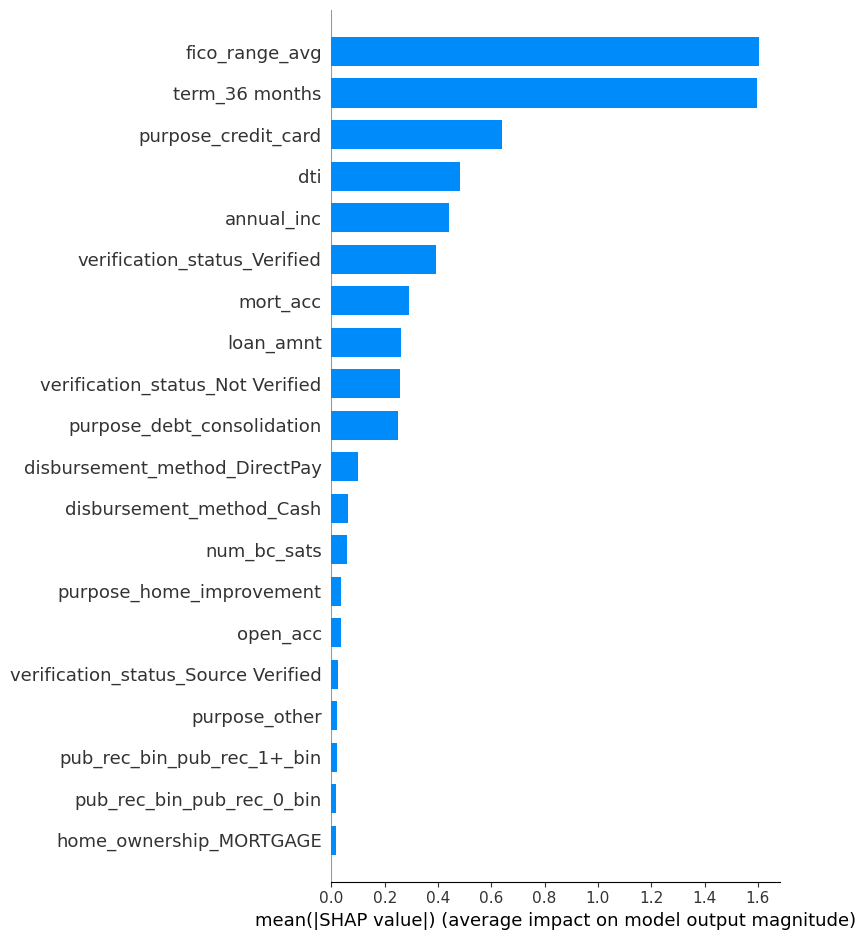

In [56]:
# Show SHAP Feature Importance

# Initiate JavaScript for visualization 
shap.initjs()

# Plot SHAP summary bar plot
shap.summary_plot(shap_values, X_encoded, feature_names=columns, plot_type='bar')

The below plot shows how the feature values affect the model output.

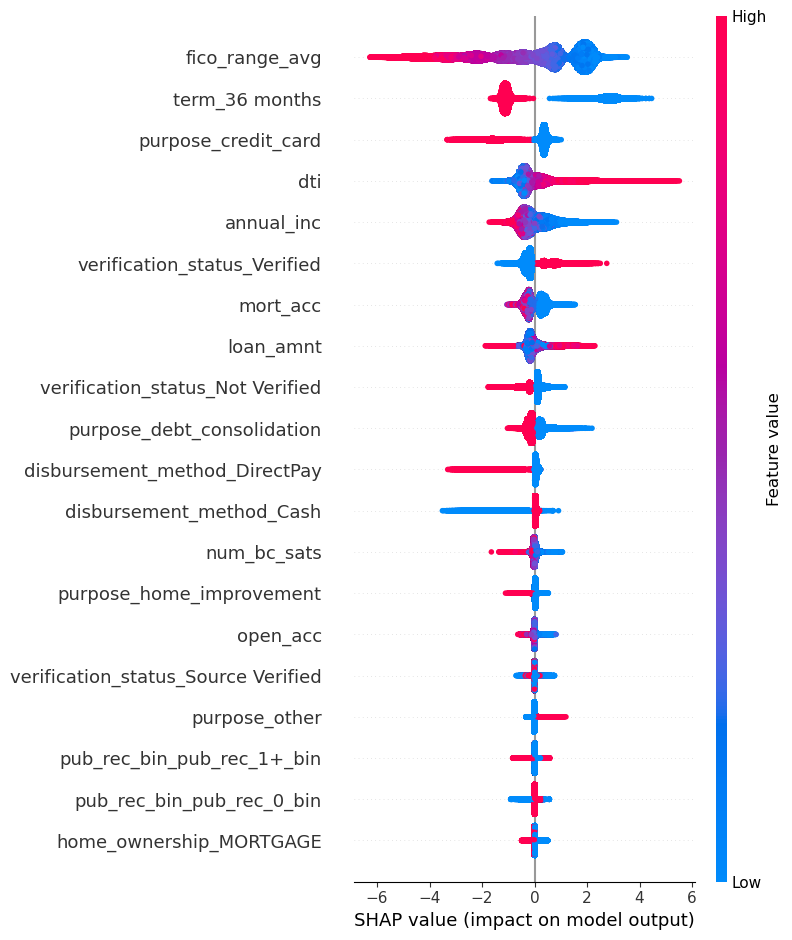

In [44]:
# Show SHAP Feature Importance impact on model output

# Initiate JavaScript for visualization 
shap.initjs()

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_encoded, feature_names=columns)

Some observations:
- Higher FICO score has negative impact on interest rates.
- If loan term was '36 months', interest rates were lower.
- If the purpose of the loan was 'credit card refinancing', interest rates were lower.
- Higher dti (debt-to-income) ratio has positive impact on interest rates.
- Higher annual income has negative impact on interest rates.

Now let us try to predict using Validation and Test sets.

---
<a id="5"></a>
### 5. Decision Tree: Model Predictions

**Predict on Validation set**

In [32]:
# Predict on Validation set
pred = dt_fitgrid.best_estimator_.predict(X_validation)
print(pred)

[14.54677686 19.22167665 13.72464088 ... 12.26003062 16.87028302
 13.720625  ]


In [33]:
# Predicted error
pred_error = y_validation - pred

In [34]:
# Show predicted error as a data frame
pd.DataFrame(pred_error)

,int_rate
2043400,-5.106777
1111111,-1.251677
1131976,-5.534641
1512342,-1.506408
749634,-0.498217
...,...
628988,0.046027
274810,-1.431335
142964,1.729969
2222476,-2.880283


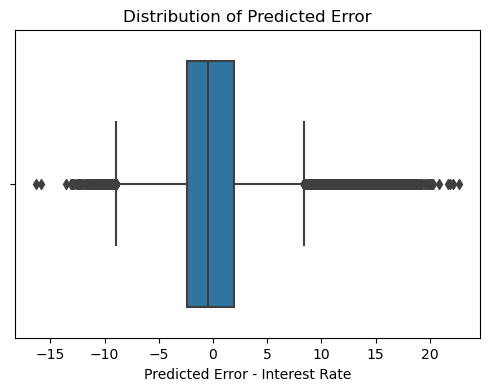

In [37]:
# Plot predicted error

# Create plot
plt.figure(figsize=(6,4))
sns.boxplot(data=pd.DataFrame(pred_error), x='int_rate')

# Set title, label, legend
plt.title('Distribution of Predicted Error')
plt.xlabel('Predicted Error - Interest Rate')

# Show plot
plt.show()

**Predict on Test set**

In [38]:
# Predict on Test set
pred = dt_fitgrid.best_estimator_.predict(X_test)
print(pred)

[15.3539823  17.11562249 10.97421053 ... 13.73015464 13.37948148
 10.2441791 ]


In [39]:
# Predicted error
pred_error = y_test - pred

In [40]:
# Actual vs Predicted interest rates
pd.DataFrame({'Actual': y_test, 'Predicted': pred, 'Error': pred_error})

,Actual,Predicted,Error
1592109,19.42,15.353982,4.066018
2103726,11.99,17.115622,-5.125622
2231437,13.49,10.974211,2.515789
1285218,14.16,15.117788,-0.957788
296051,21.67,16.279091,5.390909
...,...,...,...
507968,6.08,8.518249,-2.438249
747744,9.75,9.285984,0.464016
295840,13.99,13.730155,0.259845
572988,12.62,13.379481,-0.759481


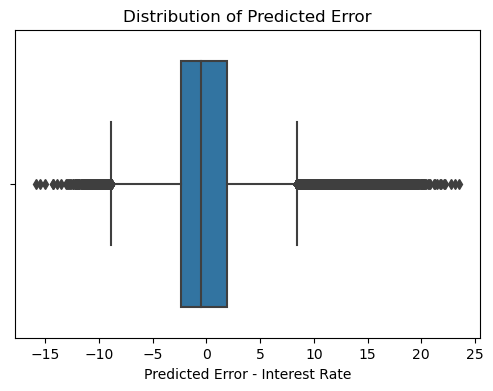

In [42]:
# Plot predicted error

# Create plot
plt.figure(figsize=(6,4))
sns.boxplot(data=pd.DataFrame(pred_error), x='int_rate')

# Set title, label, legend
plt.title('Distribution of Predicted Error')
plt.xlabel('Predicted Error - Interest Rate')

# Show plot
plt.show()

---
<a id="6"></a>
### 6. Observations

In [57]:
# Display both Best Estimator and SHAP top 10 Feature Importances data frames

display(feature_imp_df.head(10))

display(shap_imp_df.head(10))

,0
fico_range_avg,0.378763
term_36 months,0.310994
dti,0.053767
purpose_credit_card,0.051849
annual_inc,0.044917
verification_status_Verified,0.034702
loan_amnt,0.027903
verification_status_Not Verified,0.018980
mort_acc,0.016805
disbursement_method_DirectPay,0.016627


,col_name,feature_importance
36,fico_range_avg,1.603077
0,term_36 months,1.595702
3,purpose_credit_card,0.640016
32,dti,0.482309
31,annual_inc,0.439433
18,verification_status_Verified,0.391446
34,mort_acc,0.292388
30,loan_amnt,0.259639
16,verification_status_Not Verified,0.255602
4,purpose_debt_consolidation,0.251451


Let us create a table to see the top 10 Feature Importances side-by-side.

||**Decision Tree**|**Decision Tree**|
|-|-|-|
||**GridSearchCV**|**SHAP**|
|1|fico_range_avg|fico_range_avg|
|2|term_36 months|term_36_months|
|3|dti|purpose_credit_card|
|4|purpose_credit_card|dti|
|5|annual_inc|annual_inc|
|6|verification_status_Verified|verification_status_Verified|
|7|loan_amnt|mort_acc|
|8|verification_status_Not Verified|loan_amnt|
|9|mort_acc|verification_status_Not Verified|
|10|disbursement_method_DirectPay|purpose_debt_consolidation|

Let us create a table for the RMSE scores.

||Best RMSE score|
|-|-|
|Model - Decision Tree Regressor (max_depth=15, min_samples_leaf=95)|-3.6514|

The best RMSE score for our best model (as of now) i.e. Decision Tree Regressor (max_depth=15, min_samples_leaf=95) is ~ -3.65.

In the next Jupyter notebook (5_Model_Random Forest), we will focus on Random Forest model and see if we can improve the RMSE score.

**The End**